In [158]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from matplotlib import pyplot as plt


In [146]:
RED_obs = pd.read_csv("RED_Observed.csv")
RED_BOM = pd.read_csv("RED_Rainfall.csv")

In [147]:
# Set date as index and convert to datetime
RED_obs.set_index('Date',inplace=True)
RED_obs.index = pd.to_datetime(RED_obs.index, infer_datetime_format=True).astype('datetime64[ns]')

# Convert columns to numbers
RED_obs['Rainfall'] = pd.to_numeric(RED_obs['Rainfall'], errors='coerce')
RED_obs['Inflow'] = pd.to_numeric(RED_obs['Inflow'], errors='coerce')

RED_obs.head()

,Rainfall,Inflow
Date,,
2015-03-28,NaN,29099.00
2015-03-29,NaN,19058.70
2015-03-30,NaN,16047.20
2015-03-31,60.0,24437.10
2015-04-01,28.6,62824.19


In [148]:
# Convert date columns to a single datetime and set as index then remove the leftover columns
RED_BOM['Date'] = pd.to_datetime(RED_BOM[['Year','Month','Day']])
RED_BOM.set_index('Date',inplace=True)
RED_BOM.drop(['Year','Month','Day', 'Period over which rainfall was measured (days)', 'Quality'], axis=1, inplace=True)

RED_BOM.rename(columns = {'Rainfall amount (millimetres)': 'Rainfall'},inplace=True)
RED_BOM.dropna(inplace=True)
RED_BOM.head()


,Product code,Bureau of Meteorology station number,Rainfall
Date,,,
1987-01-01,IDCJAC0009,40965,0.0
1987-01-02,IDCJAC0009,40965,0.0
1987-01-03,IDCJAC0009,40965,2.0
1987-01-04,IDCJAC0009,40965,2.0
1987-01-05,IDCJAC0009,40965,140.0


In [149]:
# Combine the RED_BOM and RED_obs into one df

df = RED_obs.join(RED_BOM, lsuffix='_obs', rsuffix='_BOM') # Left Join on RED_obs
df.dropna(inplace=True)
df.head()

,Rainfall_obs,Inflow,Product code,Bureau of Meteorology station number,Rainfall_BOM
Date,,,,,
2015-03-31,60.0,24437.10,IDCJAC0009,40965.0,0.2
2015-04-01,28.6,62824.19,IDCJAC0009,40965.0,58.2
2015-04-02,34.8,62440.91,IDCJAC0009,40965.0,32.0
2015-04-03,3.0,51863.97,IDCJAC0009,40965.0,28.6
2015-04-04,4.8,37368.85,IDCJAC0009,40965.0,0.4


C:\Users\Stuart\AppData\Local\Temp/ipykernel_15384/3116539769.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  flow_decomp = seasonal_decompose(df.get('Inflow'), model='additive', freq=365)


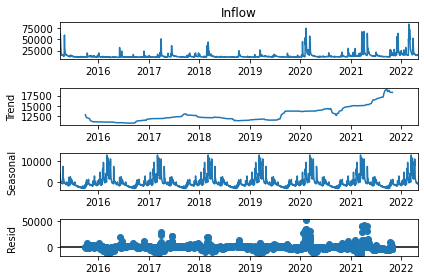

In [150]:
flow_decomp = seasonal_decompose(df.get('Inflow'), model='additive', freq=365)
flow_decomp.plot()
pyplot.show()

C:\Users\Stuart\AppData\Local\Temp/ipykernel_15384/2053231204.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  flow_decomp = seasonal_decompose(df.get('Rainfall_BOM'), model='additive', freq=365)


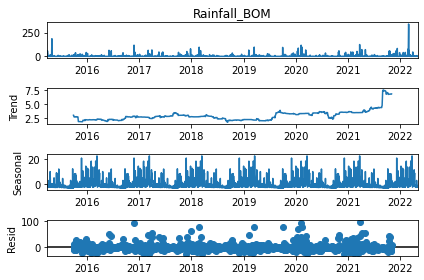

In [151]:
flow_decomp = seasonal_decompose(df.get('Rainfall_BOM'), model='additive', freq=365)
flow_decomp.plot()
pyplot.show()

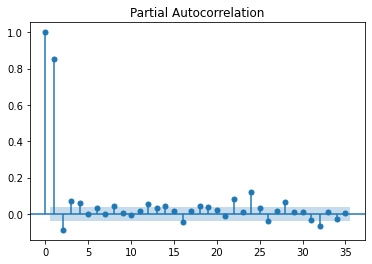

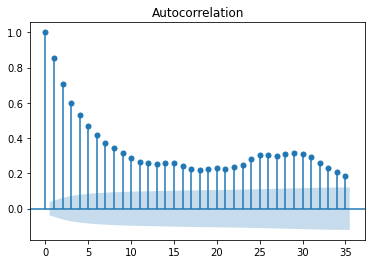

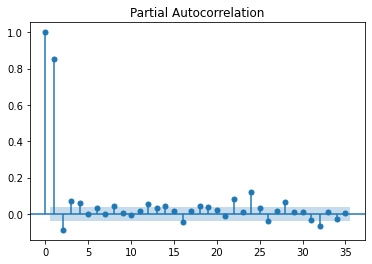

In [152]:
plot_acf(df.get('Inflow'))
plot_pacf(df.get('Inflow'))

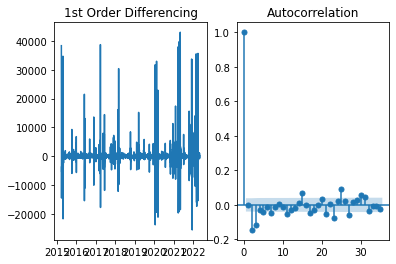

In [153]:
# Plot autocorrelation function of raw inflows
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(df.get('Inflow').diff())

ax2 = f.add_subplot(122)
plot_acf(df.get('Inflow').diff().dropna(), ax=ax2)
plt.show()

In [154]:
# Add period to index for SARIMAX
df.index = df.index.to_period('D')
df.head()

,Rainfall_obs,Inflow,Product code,Bureau of Meteorology station number,Rainfall_BOM
Date,,,,,
2015-03-31,60.0,24437.10,IDCJAC0009,40965.0,0.2
2015-04-01,28.6,62824.19,IDCJAC0009,40965.0,58.2
2015-04-02,34.8,62440.91,IDCJAC0009,40965.0,32.0
2015-04-03,3.0,51863.97,IDCJAC0009,40965.0,28.6
2015-04-04,4.8,37368.85,IDCJAC0009,40965.0,0.4


In [159]:
auto_arima(df['Inflow'], m=365, trace=True).summary()

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [156]:
# Define SARIMAX Model
order = (1,0,1)
seasonal_order = (1,0,0,365)
model = SARIMAX(df.get('Inflow'), exog = df.get('Rainfall_obs'), order=order, seasonal_order=seasonal_order)
# model = ARIMA(df.get('Inflow'), order=order).fit(transparams=False)
# Fit Model
model_fit = model.fit()

KeyboardInterrupt: 